# 1.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_colwidth', 1000)

In [3]:
df_train = pd.read_csv("agnews_train.csv")

In [4]:
df_test = pd.read_csv("agnews_test.csv")

In [6]:
# df_train = pd.read_csv("/kaggle/input/ag-news-classification-dataset/train.csv")

In [7]:
# df_test = pd.read_csv("/kaggle/input/ag-news-classification-dataset/test.csv")

In [5]:
df_train.head(20)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
1,3,Carlyle Looks Toward Commercial Aerospace (Reuters),"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
3,3,Iraq Halts Oil Exports from Main Southern Pipeline (Reuters),"Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday."
4,3,"Oil prices soar to all-time record, posing new menace to US economy (AFP)","AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections."
5,3,"Stocks End Up, But Near Year Lows (Reuters)","Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)"
6,3,Money Funds Fell in Latest Week (AP),"AP - Assets of the nation's retail money market mutual funds fell by #36;1.17 billion in the latest week to #36;849.98 trillion, the Investment Company Institute said Thursday."
7,3,Fed minutes show dissent over inflation (USATODAY.com),"USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump."
8,3,Safety Net (Forbes.com),"Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, ""buying insurance was the furthest thing from my mind,"" says Riley."
9,3,Wall St. Bears Claw Back Into the Black,"NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling band of ultra-cynics, are seeing green again."


In [9]:
df_test.head(20)

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
1,4,The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com),"SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket."
2,4,Ky. Company Wins Grant to Study Peptides (AP),"AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins."
3,4,Prediction Unit Helps Forecast Wildfires (AP),"AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning will strike in places he expects. Winds will pick up, moist places will dry and flames will roar."
4,4,Calif. Aims to Limit Farm-Related Smog (AP),"AP - Southern California's smog-fighting agency went after emissions of the bovine variety Friday, adopting the nation's first rules to reduce air pollution from dairy cow manure."
5,4,Open Letter Against British Copyright Indoctrination in Schools,"The British Department for Education and Skills (DfES) recently launched a ""Music Manifesto"" campaign, with the ostensible intention of educating the next generation of British musicians. Unfortunately, they also teamed up with the music industry (EMI, and various artists) to make this popular. EMI has apparently negotiated their end well, so that children in our schools will now be indoctrinated about the illegality of downloading music.The ignorance and audacity of this got to me a little, so I wrote an open letter to the DfES about it. Unfortunately, it's pedantic, as I suppose you have to be when writing to goverment representatives. But I hope you find it useful, and perhaps feel inspired to do something similar, if or when the same thing has happened in your area."
6,4,Loosing the War on Terrorism,"\\""Sven Jaschan, self-confessed author of the Netsky and Sasser viruses, is\responsible for 70 percent of virus infections in 2004, according to a six-month\virus roundup published Wednesday by antivirus company Sophos.""\\""The 18-year-old Jaschan was taken into custody in Germany in May by police who\said he had admitted programming both the Netsky and Sasser worms, something\experts at Microsoft confirmed. (A Microsoft antivirus reward program led to the\teenager's arrest.) During the five months preceding Jaschan's capture, there\were at least 25 variants of Netsky and one of the port-scanning network worm\Sasser.""\\""Graham Cluley, senior technology consultant at Sophos, said it was staggeri ...\\"
7,4,"FOAFKey: FOAF, PGP, Key Distribution, and Bloom Filters",\\FOAF/LOAF and bloom filters have a lot of interesting properties for social\network and whitelist distribution.\\I think we can go one level higher though and include GPG/OpenPGP key\fingerpring distribution in the FOAF file for simple web-of-trust based key\distribution.\\What if we used FOAF and included the PGP key fingerprint(s) for identities?\This could mean a lot. You include the PGP key fingerprints within the FOAF\file of your direct friends and then include a bloom filter of the PGP key\fingerprints of your entire whitelist (the source FOAF file would of course need\to be encrypted ).\\Your whitelist would be populated from the social network as your client\discovered new identit ...\\
8,4,E-mail scam targets police chief,"Wiltshire Police warns about ""phishing"" after its fraud squad chief was targeted."
9,4,"Card fraud unit nets 36,000 cards","In its first two years, the UK's dedicated card fraud unit, has recovered 36,000 stolen cards and 171 arrests - and estim

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class Index  7600 non-null   int64 
 1   Title        7600 non-null   object
 2   Description  7600 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.3+ KB


In [12]:
df_train.isnull().sum()

Class Index    0
Title          0
Description    0
dtype: int64

In [13]:
df_test.isnull().sum()

Class Index    0
Title          0
Description    0
dtype: int64

In [6]:
df_train.drop_duplicates(inplace = True)
df_test.drop_duplicates(inplace = True)

In [7]:
df_train['text'] = df_train['Title'] + ' ' + df_train['Description']

In [8]:
df_test['text'] = df_test['Title'] + ' ' + df_test['Description']

# 2.

In [9]:
df_train.rename(columns = {'Class Index': 'label'}, inplace = True)
df_test.rename(columns = {'Class Index': 'label'}, inplace = True)

In [10]:
df_train['label'] = df_train['label'] - 1 
df_test['label'] = df_test['label'] - 1
df_train['label'].value_counts()
df_train.drop(columns = ['Title', 'Description'], inplace = True)
df_test.drop(columns = ['Title', 'Description'], inplace = True)

In [19]:
df_train.head()

,label,text
0,2,"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
1,2,"Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market."
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
3,2,"Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday."
4,2,"Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections."


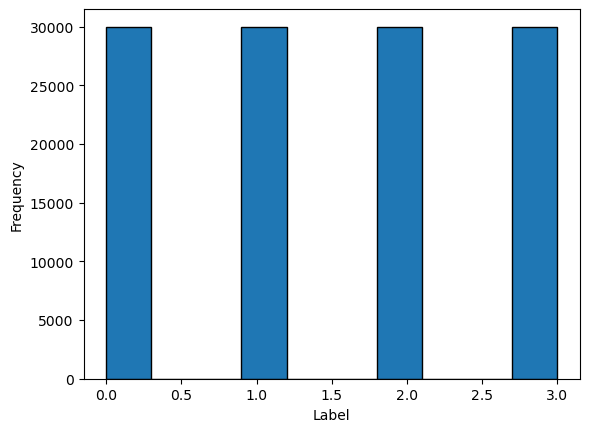

In [20]:
plt.hist(df_train['label'], edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

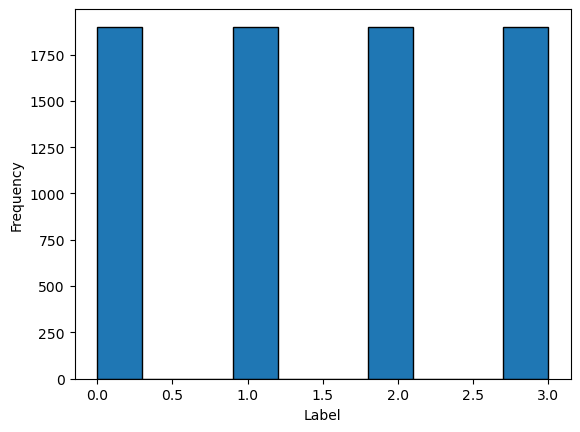

In [21]:
plt.hist(df_test['label'], edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

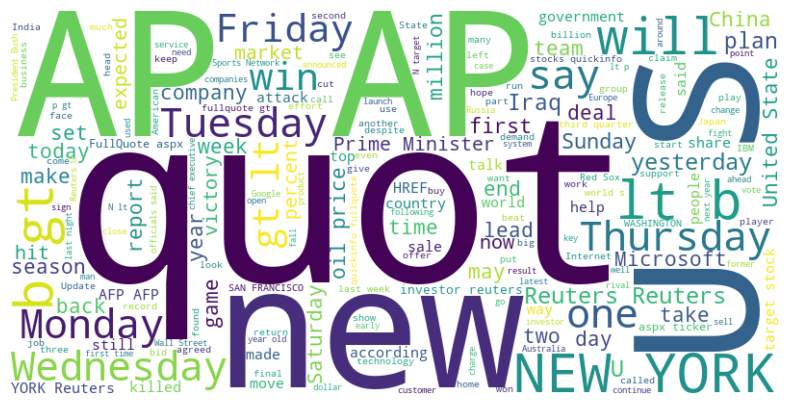

In [11]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_train['text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
import re

def contains_html(text):
  """Checks if a string contains HTML tags."""
  match = re.search('<.*?>', text)
  return bool(match)

html_rows = df_train[df_train['text'].apply(contains_html)]

html_rows.head()

,label,text


# 3.

In [108]:
import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from torch.optim import AdamW  


In [24]:
#import torchtext

In [25]:
# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

In [26]:
# import nltk
# from nltk.tokenize import word_tokenize

In [16]:
train_size = int(0.8 * len(df_train))

df_train_copy = df_train.copy()  
df_train = df_train_copy.iloc[:train_size]  
df_val = df_train_copy.iloc[train_size:] 

print(df_train.shape)  
print(df_val.shape)   

(76800, 2)
(19200, 2)


In [36]:
train_tfidf_label = df_train['label'].values
train_tfidf_text = df_train['text'].values
test_tfidf_text = df_test['text'].values
test_tfidf_label = df_test['label'].values
val_tfidf_text = df_val['text'].values
val_tfidf_label = df_val['label'].values

In [38]:
vectorizer = TfidfVectorizer(max_features=5000)

In [54]:
X_tfidf_train = vectorizer.fit_transform(train_tfidf_text)
X_tfidf_val = vectorizer.transform(val_tfidf_text)
X_tfidf_test = vectorizer.transform(test_tfidf_text)

In [40]:
print(X_tfidf_train.shape)
print(X_tfidf_val.shape)  
print(X_tfidf_test.shape)

(76800, 5000)
(19200, 5000)
(7600, 5000)


In [55]:
X_tfidf_train = X_tfidf_train.toarray()
X_tfidf_val = X_tfidf_val.toarray()
X_tfidf_test = X_tfidf_test.toarray()

In [51]:
print(vectorizer.get_feature_names_out()) 

['000' '04' '05' ... 'zone' 'zook' 'zurich']


In [84]:
X_tfidf_train, X_tfidf_train[0:1].shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 (1, 5000))

In [56]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [57]:
train_texts = df_train['text'].tolist() 
train_tokens = [tokenizer.tokenize(text) for text in train_texts]

In [58]:
val_texts = df_val['text'].tolist()
val_tokens = [tokenizer.tokenize(text) for text in val_texts]

In [59]:
test_texts = df_test['text'].tolist()
test_tokens = [tokenizer.tokenize(text) for text in test_texts]

In [60]:
train_encode = [torch.tensor(tokenizer.encode(text, truncation=True, max_length=128)) for text in df_train['text']]
val_encode = [torch.tensor(tokenizer.encode(text, truncation=True, max_length=128)) for text in df_val['text']]
test_encode = [torch.tensor(tokenizer.encode(text, truncation=True, max_length=128)) for text in df_test['text']]

In [61]:
x_train = pad_sequence(train_encode, batch_first=True, padding_value=tokenizer.pad_token_id)
x_val = pad_sequence(val_encode, batch_first=True, padding_value=tokenizer.pad_token_id)
x_test = pad_sequence(test_encode, batch_first=True, padding_value=tokenizer.pad_token_id)

In [62]:
print(x_train.shape) 

torch.Size([76800, 128])


In [63]:
train_label = df_train['label'].tolist()
val_label = df_val['label'].tolist()
test_label = df_test['label'].tolist()

In [64]:
train_label[:10]

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [65]:
y_train = torch.tensor(train_label, dtype=torch.long)
y_val = torch.tensor(val_label, dtype=torch.long)
y_test = torch.tensor(test_label, dtype=torch.long)

In [66]:
x_train, y_train, x_test, y_test, x_val, y_val

(tensor([[  101,  2813,  2358,  ...,     0,     0,     0],
         [  101, 18431,  2571,  ...,     0,     0,     0],
         [  101,  3514,  1998,  ...,     0,     0,     0],
         ...,
         [  101,  2044,  3478,  ...,     0,     0,     0],
         [  101,  2012, 23713,  ...,     0,     0,     0],
         [  101,  2859, 21857,  ...,     0,     0,     0]]),
 tensor([2, 2, 2,  ..., 2, 2, 2]),
 tensor([[  101, 10069,  2005,  ...,     0,     0,     0],
         [  101,  1996,  2679,  ...,     0,     0,     0],
         [  101, 18712,  1012,  ...,     0,     0,     0],
         ...,
         [  101, 10337,  3727,  ...,     0,     0,     0],
         [  101,  1019,  1997,  ...,     0,     0,     0],
         [  101,  1041, 15907,  ...,     0,     0,     0]]),
 tensor([2, 3, 3,  ..., 1, 2, 2]),
 tensor([[  101,  2021,  5667,  ...,     0,     0,     0],
         [  101,  3514,  3976,  ...,     0,     0,     0],
         [  101, 13183,  6290,  ...,     0,     0,     0],
         ...,

# 4.

In [88]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import log_loss

In [76]:
import warnings
warnings.filterwarnings("ignore")

In [94]:
lr = SGDClassifier(loss = "log_loss", max_iter=1, warm_start = True, learning_rate="constant", eta0=0.01, random_state=42)

best_accuracy = 0
no_improvement_count = 0
early_stopping_threshold = 5
epochs = 50

In [95]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    lr.fit(X_tfidf_train, train_tfidf_label)

    train_preds = lr.predict(X_tfidf_train)
    val_preds = lr.predict(X_tfidf_val)

    train_probs = lr.predict_proba(X_tfidf_train)
    val_probs = lr.predict_proba(X_tfidf_val)

    train_loss = log_loss(train_tfidf_label, train_probs)
    val_loss = log_loss(val_tfidf_label, val_probs)

    train_accuracy = np.mean(train_preds == train_tfidf_label)
    val_accuracy = np.mean(val_preds == val_tfidf_label)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")    
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        no_improvement_count = 0
    else:
        no_improvement_count += 1
    
    if no_improvement_count >= early_stopping_threshold:
        print("Early stopping triggered.")
        break

Epoch 1/50 - Train Loss: 0.8785 | Train Acc: 0.8542 | Val Loss: 0.8998 | Val Acc: 0.8454
Epoch 2/50 - Train Loss: 0.7141 | Train Acc: 0.8655 | Val Loss: 0.7344 | Val Acc: 0.8591
Epoch 3/50 - Train Loss: 0.6347 | Train Acc: 0.8726 | Val Loss: 0.6534 | Val Acc: 0.8665
Epoch 4/50 - Train Loss: 0.5881 | Train Acc: 0.8770 | Val Loss: 0.6056 | Val Acc: 0.8715
Epoch 5/50 - Train Loss: 0.5577 | Train Acc: 0.8807 | Val Loss: 0.5743 | Val Acc: 0.8750
Epoch 6/50 - Train Loss: 0.5365 | Train Acc: 0.8837 | Val Loss: 0.5526 | Val Acc: 0.8774
Epoch 7/50 - Train Loss: 0.5210 | Train Acc: 0.8859 | Val Loss: 0.5368 | Val Acc: 0.8796
Epoch 8/50 - Train Loss: 0.5093 | Train Acc: 0.8874 | Val Loss: 0.5249 | Val Acc: 0.8817
Epoch 9/50 - Train Loss: 0.5002 | Train Acc: 0.8887 | Val Loss: 0.5158 | Val Acc: 0.8828
Epoch 10/50 - Train Loss: 0.4931 | Train Acc: 0.8900 | Val Loss: 0.5087 | Val Acc: 0.8844
Epoch 11/50 - Train Loss: 0.4874 | Train Acc: 0.8908 | Val Loss: 0.5031 | Val Acc: 0.8853
Epoch 12/50 - Train

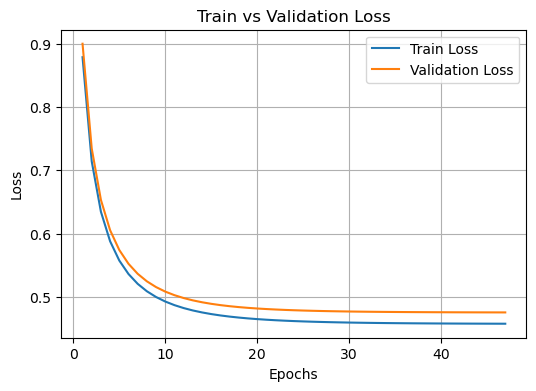

In [99]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

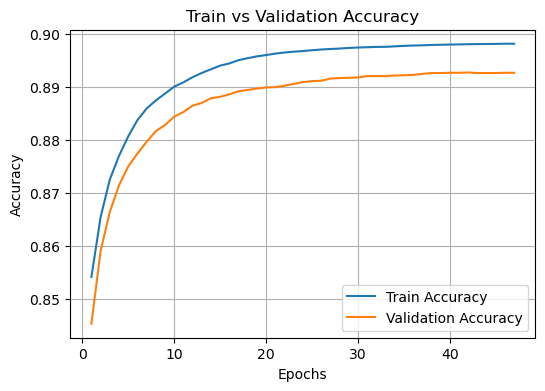

In [98]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

In [100]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_tfidf_train, train_tfidf_label)

RandomForestClassifier(random_state=42)

In [101]:
rfc_preds_test = rfc.predict(X_tfidf_test)
rfc_preds_val = rfc.predict(X_tfidf_val)

test_acc = np.mean(rfc_preds_test == test_tfidf_label)
val_acc = np.mean(rfc_preds_val == val_tfidf_label)

print(f"RF - Acc: {test_acc:.4f} | Val Acc: {val_acc:.4f}")

RF - Acc: 0.8605 | Val Acc: 0.8564


In [102]:
xgb = XGBClassifier(n_estimator = 1000, max_depth = 6, learning_rate = 0.1, eval_metric='mlogloss', random_state=42)

In [104]:
eval_set = [(X_tfidf_train, train_tfidf_label), (X_tfidf_val, val_tfidf_label)]
xgb.fit(X_tfidf_train, train_tfidf_label, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimator=1000, n_estimators=None,
              n_jobs=None, ...)

In [105]:
results = xgb.evals_result()
train_loss = results['validation_0']['mlogloss']
val_loss = results['validation_1']['mlogloss']

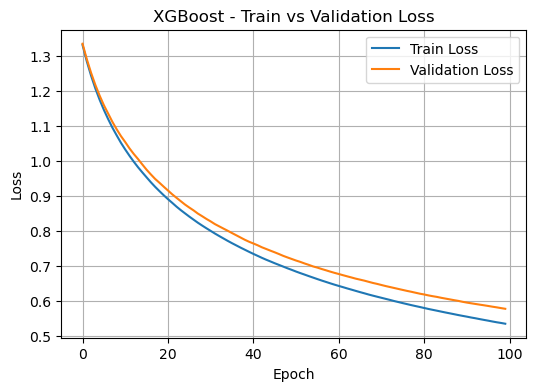

In [107]:
plt.figure(figsize=(6, 4))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("XGBoost - Train vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
class TextDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

In [ ]:
batch_size = 32

In [ ]:
train_dataset = TextDataset(x_train, y_train)
val_dataset = TextDataset(x_val, y_val)
test_dataset = TextDataset(x_test, y_test)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embd_dim, hidden_dim, output_dim, num_layers = 1):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embd_dim)
        self.lstm = nn.LSTM(embd_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.25)
        self.dense = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        last_hidden = self.dropout(lstm_out[:, -1,  :])
        output = self.dense(last_hidden)
        return output

In [ ]:
vocab_size = tokenizer.vocab_size
embd_dim = 128
hidden_dim = 256
output_dim = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = LSTM(vocab_size, embd_dim, hidden_dim, output_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-4)

criterion = torch.nn.CrossEntropyLoss()

In [ ]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    predictions = []
    targets = []
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            texts, labels = batch  
            texts, labels = texts.to(device), labels.to(device)  

            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predictions.append(outputs.argmax(dim=1))
            targets.append(labels)
    
    predictions = torch.cat(predictions)
    targets = torch.cat(targets)
    accuracy = (predictions == targets).float().mean().item()
    avg_loss = total_loss / len(data_loader)

    return avg_loss, accuracy

In [ ]:
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    epoch_loss = []
    model.train()
    total_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)  
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    train_loss, train_accuracy = evaluate(model, train_loader, criterion, device)
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

Epoch 1/10 - Train Loss: 0.6431, Train Acc: 0.6861 | Val Loss: 0.6970, Val Acc: 0.6606
Epoch 2/10 - Train Loss: 0.2936, Train Acc: 0.9030 | Val Loss: 0.3751, Val Acc: 0.8712
Epoch 3/10 - Train Loss: 0.2119, Train Acc: 0.9335 | Val Loss: 0.3124, Val Acc: 0.8960
Epoch 4/10 - Train Loss: 0.1943, Train Acc: 0.9378 | Val Loss: 0.3185, Val Acc: 0.8945
Epoch 5/10 - Train Loss: 0.1756, Train Acc: 0.9416 | Val Loss: 0.2930, Val Acc: 0.8989
Epoch 6/10 - Train Loss: 0.1515, Train Acc: 0.9514 | Val Loss: 0.2953, Val Acc: 0.8959
Epoch 7/10 - Train Loss: 0.1418, Train Acc: 0.9538 | Val Loss: 0.3095, Val Acc: 0.8966
Epoch 8/10 - Train Loss: 0.1180, Train Acc: 0.9618 | Val Loss: 0.3006, Val Acc: 0.9014
Epoch 9/10 - Train Loss: 0.1096, Train Acc: 0.9641 | Val Loss: 0.3113, Val Acc: 0.8983
Epoch 10/10 - Train Loss: 0.1075, Train Acc: 0.9678 | Val Loss: 0.3026, Val Acc: 0.8987


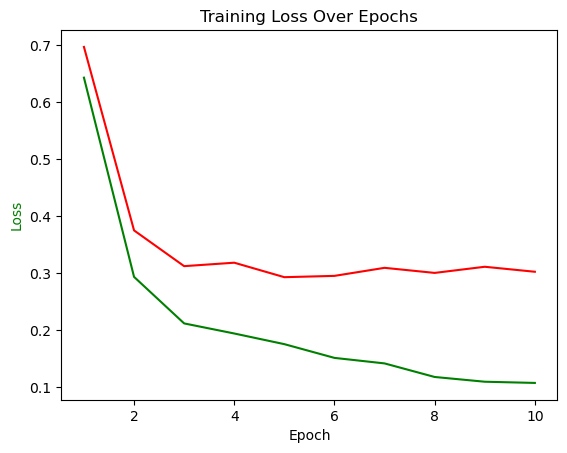

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(range(1, num_epochs+1), train_losses, 'g-', label='Training Loss')
ax1.plot(range(1, num_epochs+1), val_losses, 'r-', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='g')
plt.title('Training Loss Over Epochs')
plt.show()

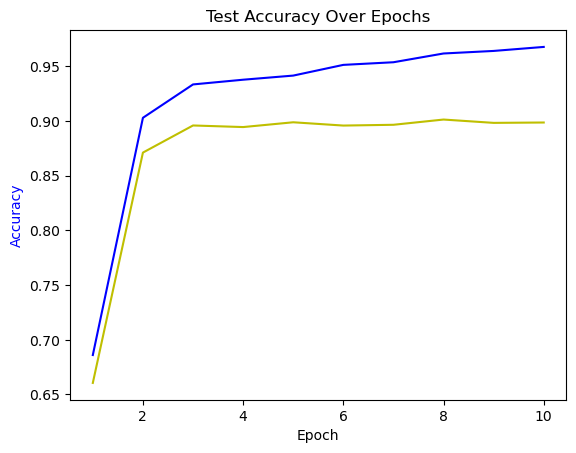

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(range(1, num_epochs+1), train_accuracies, 'b-', label='Training Accuracy')
ax1.plot(range(1, num_epochs+1), val_accuracies, 'y-', label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='b')
plt.title('Test Accuracy Over Epochs')
plt.show()

In [109]:
from transformers import RobertaForSequenceClassification

In [111]:
model_name = "roberta-base"
num_labels = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [112]:
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

criterion = torch.nn.CrossEntropyLoss()

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
